In [10]:
import main
from main import StepResult, ElasticData, CalculationResult
import network
import matplotlib.pyplot as plt
import convert
import os

In [2]:
opt_dir = "/home/sergey/work/auxetic_optimizer/pos_test"
opt_history = main.load_optimization_log(os.path.join(opt_dir, "optimization_log.pkl"))

In [18]:
steps = [i+1 for i in range(len(opt_history))]
Bs = [step.dG.bulk_modulus for step in opt_history]
Gs = [step.dG.shear_modulus for step in opt_history]
Ps = [step.dG.p_ratio for step in opt_history]
Zs = [step.network.coordination_number for step in opt_history]

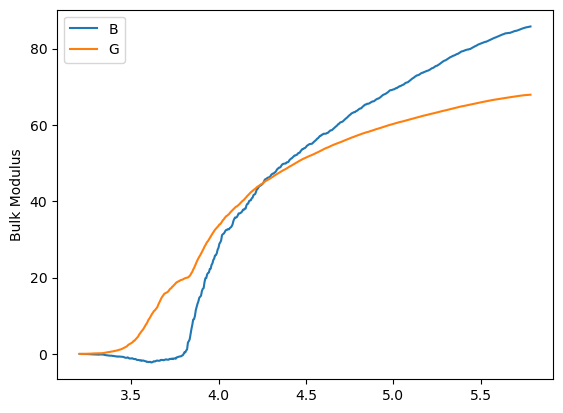

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=1)

# axs[0].plot(Zs, Bs, label='B')
# axs[0].set_ylabel("Bulk Modulus")
# axs[0].set_xlabel("Step")

axs.plot(Zs, Bs, label='B')
axs.plot(Zs, Gs, label='G')
# axs.plot(Zs, Ps, label='p')
axs.set_ylabel("Bulk Modulus")
# axs.set_ylim(-0.1, 0.4)
# axs.set_xlabel("Z")
# axs[1].plot(Zs, Gs, label='G')
# axs[1].set_ylabel("Shear Modulus")
# axs[1].set_xlabel("Step")

# axs[2].plot(Zs, Ps, label='P')
# axs[2].set_ylabel("P ratio")
# axs[2].set_xlabel("Step")

plt.legend()
plt.show()
